# Image Classification ML Assignment 

The goal of this assignment is to learn fundamentals of machine learning and image analysis. You will analyze images from Happy Whale, an organization that tracks whales globally, and modify a classifier for these images. 

Part 1: Walk through (Due Feb 27)
- In class, we will walk through the provided code
- This script has several functions that are written for you. For part 1, please do NOT modify any code unless it specifies to change it.
- Answer the questions as you go through the code

Part 2: Make modifications (Due Feb 27)
- Change model parameters or other model aspects at least 3 times 
- Describe what happened when you made these changes

Part 3: Create a team, get inspired and try a new approach to your model (Due March 6)
- Have a group meeting and record your meeting with audio or video (you can record with zoom!)
    - Start by discussing part 2 of the assignment:
        - What approaches you each took to change the ML model in part 2
        - What are similarities and differences between your approaches 
        - What types of changes improved model performance
        - What types of changes made model performance worse
        - Based on the whole group's work, what would y'all want to do next in terms of model optimization?
    - Next, look at code and approaches from the [Happy Whales competition leaderboard](https://www.kaggle.com/competitions/happy-whale-and-dolphin/leaderboard).
        - Is there any strategy that someone used that you could implement? 
            - Ex: learning rate value, # epochs, transformation strategy, or more complex changes to the models
        - Are there strategies that you are interested in learning about?
    - Lastly, make a plan for 1 more round of model optimization
        - Assign each member something to attempt for training the model. Use your cumulative experience to decide the most important things to test. 
        - Group members can make as small as changing the value for a parameter or as big as changing the model.
- Have each member complete their test
- Share results with each other
- Write a 1-3 paragraph summary on your group's attempts and recommendations moving forward
- For Part 3: Turn in the audio/video recording of the group meeting, each member's code (uploaded to their original git repo), and the team's 1-3 paragraph summary over canvas.

### Your choices on data
You can chose between 3 datasets for this assignment. This jupyter notebook is set up using the Species dataset. If you change the dataset, you will need to change the number of classes parameter for the model.
- Species = you will classify images by species (gray, killer, beluga, humpback, false killer, and common dolphin)
  - File path: /projects/bgmp/shared/Bi625/ML_Assignment/Datasets/Whale_species/species
- Species_all = you will classify images by species (minke, gray, killer, beluga, humpback, false killer, and bottlenose and common dolphin). There are a high number of images for bottlenose dolphins and minke whales which leads to this dataset being quite large. Due to the size of the dataset, it has a longer training time than the "Species" dataset.
  - File path: /projects/bgmp/shared/Bi625/ML_Assignment/Datasets/Whale_species/species_all
  - Num classes: 8
- Individuals = you will classify images by individuals. This is a much more challenging classification task because you have different individuals from different species. However, this was the original goal of the Happy Whale competition, so try challenging yourself to this important task!
  - File path: /projects/bgmp/shared/Bi625/ML_Assignment/Datasets/Whale_species/individuals
  - Num classes: 110

You are NOT graded by the success of your model, so you are free to train the model on whichever dataset is more interesting to you. However, **everyone on your team for part 3 should be using the same dataset**.

### Part 1

In [2]:
## Importing packages - Please DO NOT alter this box ##
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data.sampler import WeightedRandomSampler
torch.manual_seed(0)

from captum.attr import IntegratedGradients
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

import torchvision
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
from scipy.ndimage import binary_erosion
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

import wandb #comment this out if you are not using weights and biases
import random #comment this out if you are not using weights and biases

# Set device to cuda if it's available otherwise default to "cpu"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading in the dataset

By default, this will load in the species dataset, this is the smallest dataset (i.e., it will be relatively fast to train) and has a simple goal (i.e., you will be able to create an accurate model). If you want a challenge, I highly encourage you to try the Species_all (a dataset with 2 additional species) or the individual dataset (a dataset where whales are characterized by individual rather than species).

In [3]:
images = "/projects/bgmp/shared/Bi625/ML_Assignment/Datasets/Whale_species/species"

In [4]:
# We must turn our images into tensors, resize, and normalize them 
# We can also add additional transformations to images 
transform = transforms.Compose([transforms.ToTensor(), 
                                #We will start with a model called Resnet18 that is optimized for 224x224 images
                                #It is set to a very SMALL size initially so the model will train fast in class
                                transforms.Resize([32,32]),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize the data, these are the values that ResNet suggests based on their training data (natural scences)
                               ])
all_images = datasets.ImageFolder(images, transform)
print(all_images)

Dataset ImageFolder
    Number of datapoints: 2794
    Root location: /projects/bgmp/shared/Bi625/ML_Assignment/Datasets/Whale_species/species
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[32, 32], interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


<font color='magenta'>What is the purpose(s) of transforming image data? (2 pts)

Transforming the image data allows us to 1) convert the image to a tensor, which can be used by tensorflow, 2) resize the input images to a specific, uniform size, and 3) normalize the data for the ResNet model to converge faster and perform better.

<font color='green'>The below code completes the image transformations as coded in the above box.

In [5]:
all_images = datasets.ImageFolder(images, transform )
print(len(all_images))
print(all_images)

2794
Dataset ImageFolder
    Number of datapoints: 2794
    Root location: /projects/bgmp/shared/Bi625/ML_Assignment/Datasets/Whale_species/species
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[32, 32], interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


Our classification labels will be converted to indices, we can determine which indices is which label using the below code

In [6]:
print(all_images.class_to_idx)

{'beluga': 0, 'common_dolphin': 1, 'false_killer_whale': 2, 'fin_whale': 3, 'gray_whale': 4, 'humpback_whale': 5}


<font color='green'>The below function is used to randomly select dataset images to evaluate how the transformations altered the images.

In [7]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0], cmap="viridis")                     # show the image, cmap is the color map that the image is being shown in
    #axarr[1].imshow(mask[0])                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    print(img.shape)
    plt.show()

Image size is {torch.Size([32, 32])}
torch.Size([3, 32, 32])


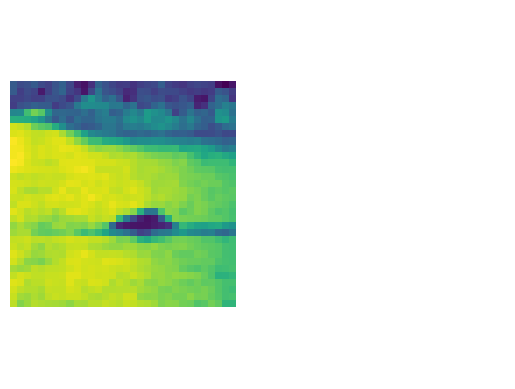

In [8]:
show_random_dataset_image(all_images)

<font color='magenta'>What is the difference between image size and torch image size? (2 pts)

The image size is 2D, representing width and height, whereas a torch image size in PyTorch is multidimensional, with a dimension representing color channels.

<font color='magenta'>Add a new transformation to the training data. After your first run of this model during class time, resize the image to 224x224 pixels. (2 pts)

Image size is {torch.Size([224, 224])}
torch.Size([3, 224, 224])


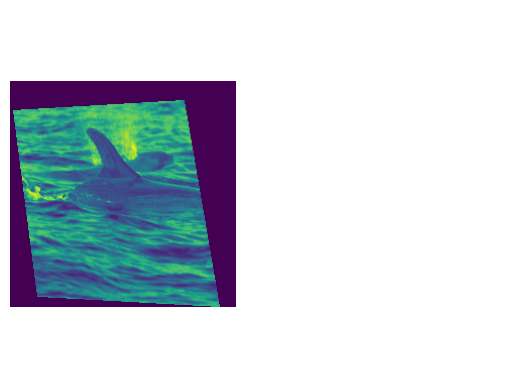

In [9]:
## ADD YOUR TRANSFORMATION HERE
transform = transforms.Compose([
            transforms.Resize([224,224]), # Resize the image as our model is optimized for 224x224 pixels
            transforms.RandomPerspective(distortion_scale=0.6, p=1.0), # Random perspective distortion with a 100% probability
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # Normalize the data, these are the values that ResNet suggests based on their training data (natural scences))

all_images = datasets.ImageFolder(images, transform )
show_random_dataset_image(all_images)

<font color='magenta'>How did your transformation impact the images? (1 pt)

The random perspective transformation performs a random perspective transform on the image, making it look tilted and distorted. It's also resized to be more "zoomed out" with the resize transformation.

### Creating datasets used in training and testing

After loading in the data, we separate the data into training, validation, and testing datasets. The training data is inputted into the model during the training phase, and the model's predictions from this data is used to modulate the weights of the model. The validation data is used while the model trains, but the model is in a evaluation rather than training mode. The validation data gives us a real time view on how accurately the model is predicting our labels. The testing data is used after the model has completed training and tells us how successful our model will be with a novel dataset.

Once creating these 3 datasets, we prepare dataloaders which are used to load the images into our models. These images are loaded in batches into the model (a parameter called batch size). Because our dataset is imbalanced, we use a weighted random sampler to select images for our batches in the dataloader. Therefore to create our dataloader, we start by creating a function to get weights, calculating weights, initiating our weighted random sampler, and then creating our dataloaders.

<font color='green'>The below code eastablishes the data split between training, validation, and testing.

In [10]:
train_size = int(0.7 * len(all_images))
val_size = int(0.15 * len(all_images))
test_size = len(all_images) - (train_size + val_size)
print(train_size, val_size, test_size)
assert train_size + val_size + test_size == len(all_images)

1955 419 420


In [11]:
train_set, val_set, test_set = torch.utils.data.random_split(all_images, [train_size, val_size, test_size])

<font color='green'>The below function is used to get weights for the image classes.

In [12]:
def _get_weights(subset,full_dataset):
    ys = np.array([y for _, y in subset])
    counts = np.bincount(ys)
    label_weights = 1.0 / counts
    weights = label_weights[ys]

    print("Number of images per class:")
    for c, n, w in zip(full_dataset.classes, counts, label_weights):
        print(f"\t{c}:\tn={n}\tweight={w}")
        
    return weights

In [13]:
train_weights = _get_weights(train_set,all_images)
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))

Number of images per class:
	beluga:	n=461	weight=0.0021691973969631237
	common_dolphin:	n=54	weight=0.018518518518518517
	false_killer_whale:	n=718	weight=0.001392757660167131
	fin_whale:	n=119	weight=0.008403361344537815
	gray_whale:	n=53	weight=0.018867924528301886
	humpback_whale:	n=550	weight=0.0018181818181818182


<font color='magenta'>What is the impact of the class weight on how data is loaded into the model? What does it mean if a class has a low vs high weight? (2 pts)

<details>
  <summary>Hint</summary>
  
Check out this resource: https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452 


Class weights determine how frequently samples from each class are selected as data is loaded into the model. A higher weight increases the probability that a sample from that class is chosen, while a lower weight decreases it. In imbalanced datasets, classes with a higher representation are assigned lower weights so they are sampled less often, and classes with a lower representation are assigned higher weights so they are sampled more often, helping balance the dataset.

In [14]:
train_loader = DataLoader(train_set, batch_size=48, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=48, drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=48, drop_last=True, shuffle=True)

### Picking hyperparameters

We can set a few hyperparameters that we decide and can tune. These include:

- Learning rate = how much to update our model's parameters at each batch/epoch
- batch size = the number of data samples to pass through the network before updating it
    - If you change the batchsize below, make sure you ALSO change it in the commands above for the DataLoader
- Number of epochs = # of times to iterate over the dataset in model training

In [15]:
learning_rate=1e-3
batchsize=48
epochs=5

<font color='magenta'>How would model training be impacted if we decreased our learning rate? What about if we increased it? (2 pts)

The learning rate controls how much a model adjusts its internal parameters (weights) during training, at each step of the algorithm. If the learning rate is decreased, the model training would be more stable and precise, but can be slow. If the learning rate is increased, there may be faster convergence initially, but this runs a risk of "overshooting" the optimal solution.

### Training our model

For part 1, we are going to use the model ResNet18. This is a published model for imaging data. Resnet18 is built from 4 residual blocks with two convolutional layers (Conv2d). Each convolutional layer is followed by a batch normalization step (BatchNorm2D) and a ReLU activation layer (ReLU). There is also a shortcut connection which adds input to output and allows the network to learn residual mapping.

I provided the complete code for the ResNet18 model. In the future, if you want to use resnet18, you can load it simply by running `resnet18_model = torchvision.models.resnet18(weights = False, progress  = True, num_classes=XXX)`. We will look at the full code for the model so you can see how this model was created.  

<font color='green'>The below code builds the residual blocks that ResNet18 uses in the model.

In [16]:
## First, we create the basic block that will be used in our residual net
class BasicBlock(nn.Module):
    # Initializing method for the basic block (It's OOP!)
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        ## Conv1: convolution layer, batch normalization, ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        ## Conv2: convolution layer, batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        ## Shortcut connection: adds input to output
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    # The forward method calls on each layer
    def forward(self, x):
        ## Conv1: convolution layer, batch normalization, ReLU activation
        out = self.conv1(x) 
        out = self.bn1(out)
        out = self.relu(out)
        ## Conv2: convolution layer, batch normalization
        out = self.conv2(out)
        out = self.bn2(out)
        ## Shortcut connection
        out += self.shortcut(x)
        ## Final activation
        out = self.relu(out)
        return out

<font color='green'>The below code builds and initializes the ResNet18 model.

In [17]:
## Next, we put together these building blocks and create our residual net
class ResNet18(nn.Module):
    # specify the number of classes that we are predicting
    def __init__(self, num_classes=6):
        super(ResNet18, self).__init__()
        # In channels = Num pixels in H + Num pixels in W
        self.in_channels = 64
        
        # First convolution set (convolution, batch norm, relu)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Our building blocks
        # The numbers correspond to the matrix shape
        ### We increase the number of filters/channels (i.e., the first number) as we go
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Average pooling 
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Final layer that makes the classification
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # First convolution set (convolution, batch norm, relu)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Our 4 building blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        # Final layer that makes the classification
        out = self.fc(out)
        return out

## Getting our model and transferring it to the GPU
model = ResNet18().to(device)
print(model)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

<font color='green'>The below code eastablishes the loss function and optimizer used in training the model.

In [18]:
#define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<font color='green'>The below functions are used to train, evaluate, and test the Machine Learning model.

In [19]:
wandb.init(
    project="BGMP_HappyWhale",
    name="Joyce-HappyWhale-SpeciesDataset-hyperparameters", ### Update with your name!
    config={"learning rate":0.001,
        "architecture": "CNN",
        "dataset": "Species",
        "epochs":5}
)

num_epochs = epochs
train_losses, train_acc_list, val_losses, val_acc_list = [], [], [],[]

for epoch in range(num_epochs):
    # Setting model to "training mode"
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    batch=0

    # For each batch of data within the loader
    for inputs, labels in train_loader:
        # Send our input images and their labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Inputting our training images into the model
        # and Predicting the image classification label
        outputs = model(inputs)
        # Figuring out the loss from our predictions
        loss = criterion(outputs, labels)
        # Compute gradients (aka backward pass)
        loss.backward()
        # Update model parameters
        optimizer.step()

        # Adding the loss to our running sum
        # Loss is calculated for each batch within an epoch
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        batch+=1
        print(f'Epoch [{epoch+1}/{num_epochs}] | Batch #{batch} | Batch Accuracy {(correct/total)*100:.2f}%')


    # Getting metrics for our training pass 
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_acc_list.append(train_acc)
    
    # Switching our model to "evaluation mode"
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    # Disable gradient calculation b/c we are evalulating the model
    with torch.no_grad():
        # Load in batches of our validation data
        for inputs, labels in val_loader:
            # Send test images and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Predict the image classification label
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            # Figuring out how many predicted labels = true labels
            correct += predicted.eq(labels).sum().item()

            # Figuring out the loss from our predictions
            loss = criterion(outputs, labels)
            # Adding the loss to our running sum
            # Loss is calculated for each batch within an epoch
            running_loss += loss.item() * inputs.size(0)
    # Getting our accuracy from our test data
    val_acc = 100. * correct / total
    val_acc_list.append(val_acc)
    # Getting the loss from our test data
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.2f}%')

    # log metrics to wandb
    wandb.log({"validation_accuracy": val_acc, "validation_loss": val_loss, "train_loss":train_loss})

wandb.finish()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/joycew/.netrc.
wandb: Currently logged in as: joycew (BGMP_HappyWhale) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/5] | Batch #1 | Batch Accuracy 10.42%
Epoch [1/5] | Batch #2 | Batch Accuracy 20.83%
Epoch [1/5] | Batch #3 | Batch Accuracy 19.44%
Epoch [1/5] | Batch #4 | Batch Accuracy 21.88%
Epoch [1/5] | Batch #5 | Batch Accuracy 25.00%
Epoch [1/5] | Batch #6 | Batch Accuracy 28.82%
Epoch [1/5] | Batch #7 | Batch Accuracy 31.55%
Epoch [1/5] | Batch #8 | Batch Accuracy 32.81%
Epoch [1/5] | Batch #9 | Batch Accuracy 35.19%
Epoch [1/5] | Batch #10 | Batch Accuracy 37.08%
Epoch [1/5] | Batch #11 | Batch Accuracy 38.26%
Epoch [1/5] | Batch #12 | Batch Accuracy 40.45%
Epoch [1/5] | Batch #13 | Batch Accuracy 41.51%
Epoch [1/5] | Batch #14 | Batch Accuracy 42.71%
Epoch [1/5] | Batch #15 | Batch Accuracy 43.06%
Epoch [1/5] | Batch #16 | Batch Accuracy 43.88%
Epoch [1/5] | Batch #17 | Batch Accuracy 44.49%
Epoch [1/5] | Batch #18 | Batch Accuracy 45.49%
Epoch [1/5] | Batch #19 | Batch Accuracy 46.05%
Epoch [1/5] | Batch #20 | Batch Accuracy 46.56%
Epoch [1/5] | Batch #21 | Batch Accuracy 47.32%
E

train_loss,█▃▂▂▁
validation_accuracy,▁▅▇█▅
validation_loss,█▅▁▃▂
train_loss,0.80287
validation_accuracy,53.38542
validation_loss,1.16457


#### For our class training, run the below model and consider the success of the model training. 

<font color='magenta'>What is your starting accuracy and final accuracy? What happened to the model to change the accuracy from epoch 1 to 5? (2 pts)

The starting accuracy was 30.47%% and the final accuracy was 53.39%. From epoch 1 to epoch 5, the accuracy increased because the model is iteratively refining its internal parameters (weights and biases) during training to better map inputs to correct outputs, and to reduce the loss (error).

If the final accuracy was lower than the starting accuracy, however, perhaps overfitting occurred, where the model is too complex (too many parameters/layers) or trained for too long, causing it to learn the noise, errors, or specific quirks in the training dataset.

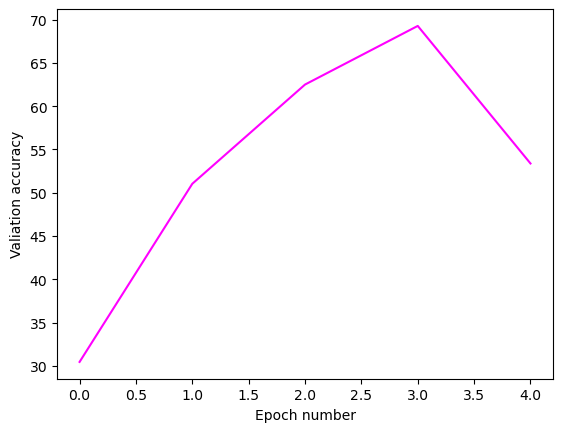

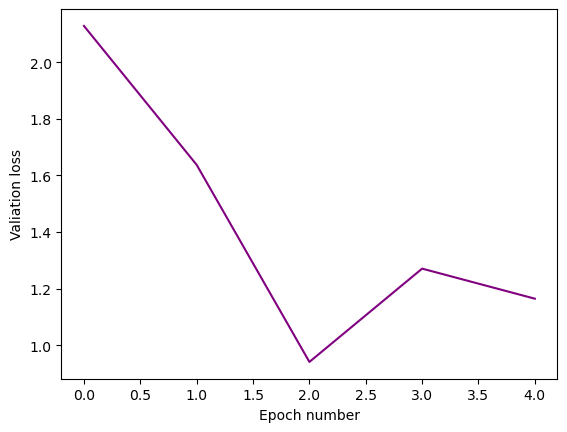

In [21]:
plt.plot(range(num_epochs), val_acc_list, color = "magenta")
plt.xlabel("Epoch number")
plt.ylabel("Valiation accuracy")
plt.show()  

plt.plot(range(num_epochs), val_losses, color = "purple")
plt.xlabel("Epoch number")
plt.ylabel("Valiation loss")
plt.show() 

<font color='green'>After running the model and calculating the overall accuracy, we can examine the data via a confusion matrix which highlights the accuracy by class.

[0 2 2 2 0 4 2 2 2 5 3 2 0 5 3 5 2 0 0 5 5 2 2 2 2 0 5 3 5 5 5 5 3 2 2 5 2
 2 2 4 5 5 4 5 2 5 0 2 2 2 2 5 2 5 2 3 0 2 5 0 0 0 2 5 0 5 0 2 0 5 5 2 2 0
 2 2 2 3 2 0 2 5 0 0 2 5 2 2 5 0 5 0 0 2 2 0 5 0 2 0 0 5 0 5 2 0 0 0 5 2 5
 2 0 2 1 5 5 5 2 2 1 5 5 2 5 2 5 5 2 5 5 0 0 4 5 5 5 2 5 2 5 5 5 0 0 5 1 0
 0 4 4 2 2 5 5 5 2 4 0 0 2 0 2 0 2 5 5 3 2 2 5 2 0 5 2 0 5 5 5 2 5 5 5 3 0
 2 5 2 5 2 0 0 0 3 5 2 3 3 3 0 5 0 2 0 2 5 2 2 2 1 4 2 2 0 0 2 0 2 0 0 2 2
 2 0 0 0 5 0 0 0 5 0 2 5 2 2 5 5 0 2 4 2 2 2 2 0 5 5 2 5 5 2 5 5 5 0 5 0 2
 2 5 0 2 2 5 0 5 2 0 5 5 5 2 2 2 5 2 2 3 0 2 0 2 0 5 0 3 5 2 5 2 3 1 2 5 5
 5 0 4 2 0 5 2 0 4 2 5 0 2 5 5 5 2 0 2 5 5 5 0 3 5 4 2 0 2 2 5 5 5 0 3 5 3
 0 5 0 5 2 0 1 2 5 0 5 5 2 2 0 1 0 2 5 5 0 2 5 3 5 5 0 5 5 5 0 5 0 2 3 5 0
 2 0 2 5 5 5 2 5 2 2 2 2 2 0 5 0 2 0 5 5 5 2 3 5 2 0 2 5 0 2 5 2 2 5 3 2 5
 0 5 2 2 1 2 0 0 2 2 4 0 5]


/tmp/ipykernel_1235375/2764316866.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


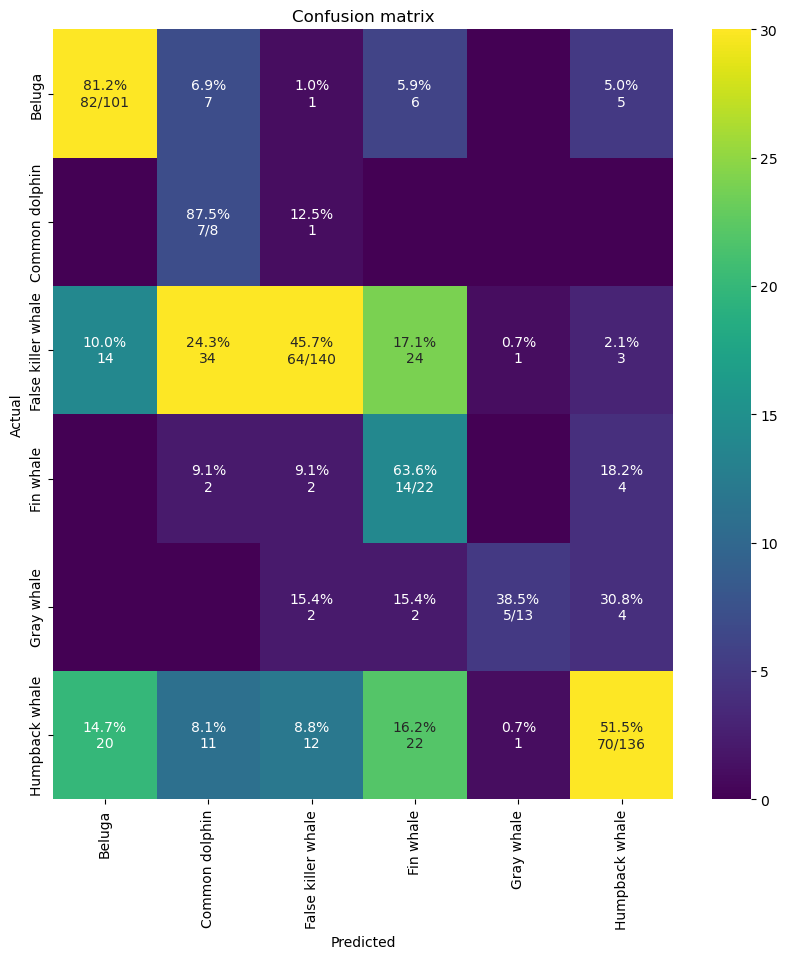

In [22]:
# predict the test dataset
def predict(model, dataset):
    dataset_prediction = []
    dataset_groundtruth = []
    model = model
    with torch.no_grad():
        for x, y_true in dataset:
            inp = x[None]
            y_pred = model(inp)
            dataset_prediction.append(y_pred.argmax().cpu().numpy())
            dataset_groundtruth.append(y_true)
    
    return np.array(dataset_prediction), np.array(dataset_groundtruth)
            
    # create seaborn heatmap with required labels
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    ax.set_title(title)

# Plot confusion matrix 
# orginally from Runqi Yang; 
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, title, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels = ['Beluga','Common dolphin', 'False killer whale', 'Fin whale', 'Gray whale','Humpback whale']
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
                              
    x_axis_labels = ['Beluga','Common dolphin', 'False killer whale', 'Fin whale', 'Gray whale','Humpback whale'] # labels for x-axis
    y_axis_labels = ['Beluga','Common dolphin', 'False killer whale', 'Fin whale', 'Gray whale','Humpback whale'] # labels for y-axis
    ax=sns.heatmap(cm, annot=annot, fmt='', vmax=30, xticklabels=x_axis_labels, yticklabels=y_axis_labels, cmap = "viridis")
    ax.set_title(title)

## This plot only contains the test set of data
## The test set of data has not been seen by the model yet
y_pred, y_true = predict(model, test_set)

print(y_true)
cm_analysis(y_true, y_pred, "Confusion matrix")

### What features did the model use to make decisions?

Based on the confusion matrices and validation loss, it is clear that the model is learning. To determine the features that are involved in decision making, there are a few possible approaches. One options is shown below, integrated gradients. 

#### Understanding feature importance using Integrated Gradients

<font color='green'>Integrated gradients is an attribution method. Attribution methods score the input data based on the prediction that the model makes using scores for each feature. The gradient is the signal that tells the network how much to increase or decrease a certain weight in the network during backpropogation. These gradients are overlaid onto the images to showcase the regions on the images that influence the weights.

Run the below code. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..0.9485404].


Annotated whale species 0
Predicted whale species 4


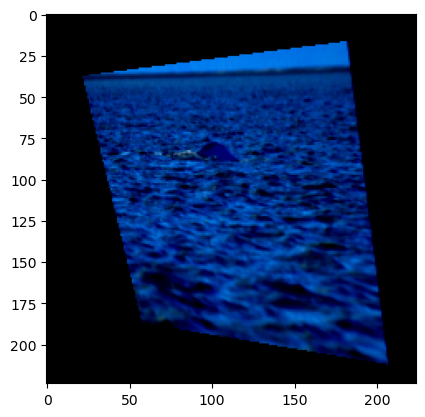

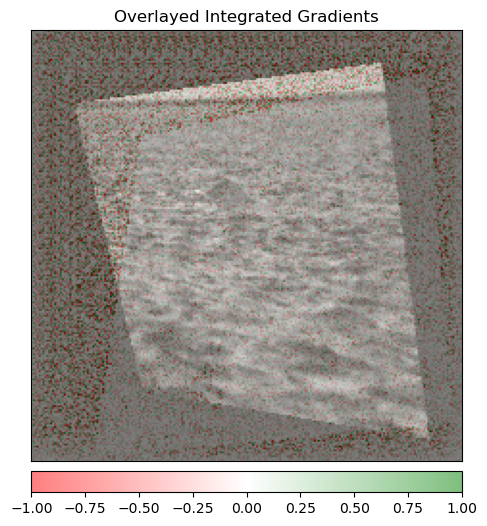

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7764271].


Annotated whale species 2
Predicted whale species 4


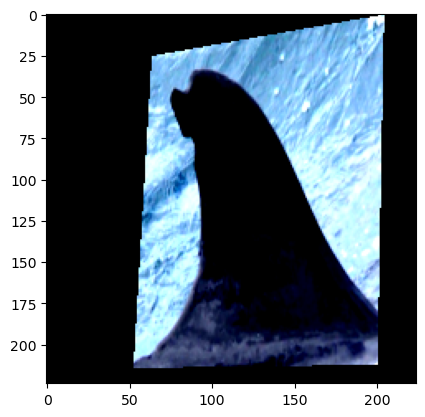

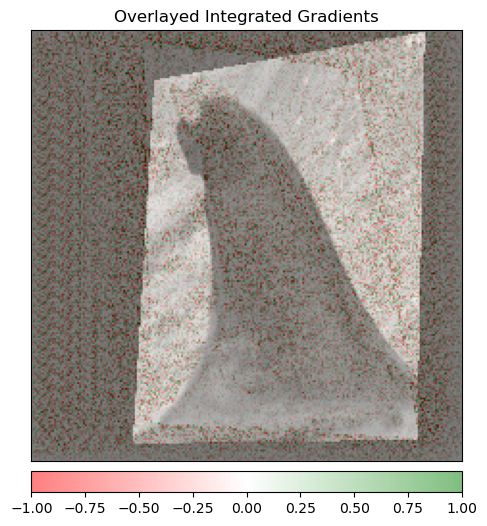

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.3755556].


Annotated whale species 5
Predicted whale species 4


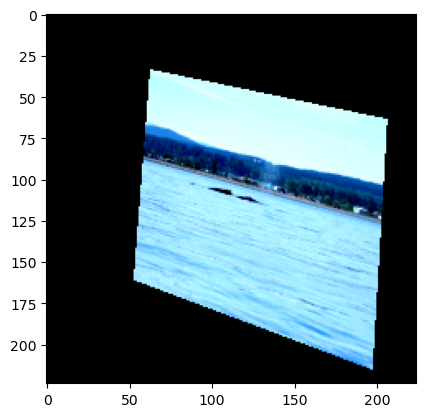

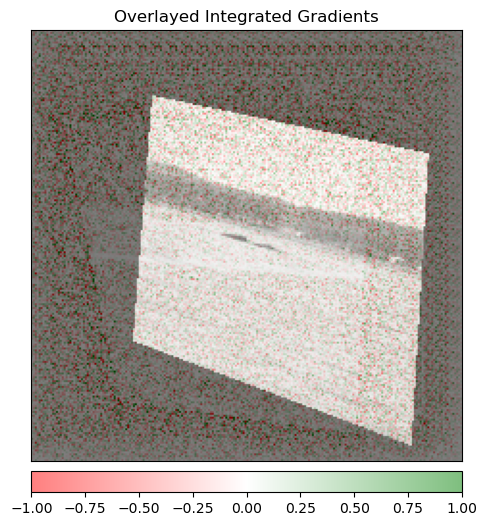

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.3842702].


Annotated whale species 3
Predicted whale species 4


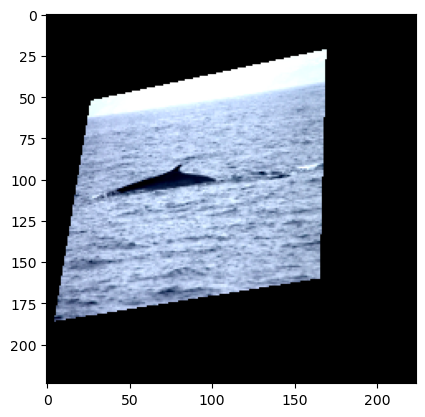

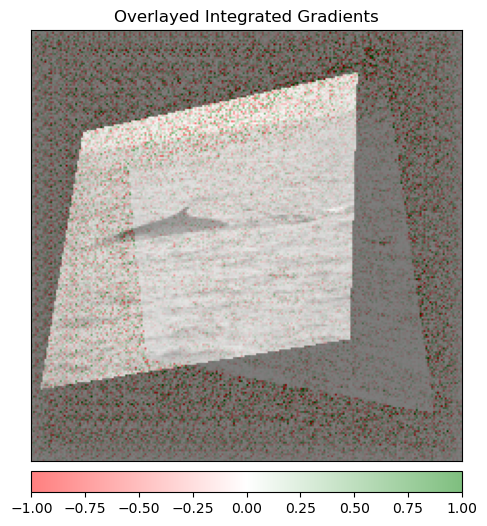

In [21]:
def visualize_ig(idx, 
                 _train_dataset=train_set, 
                 _test_dataset=test_set):
        
    # Get corresponding input and target tensors:
    input_tensor = _test_dataset[idx][0].unsqueeze(0)
    input_tensor.requires_grad = True
    target = _test_dataset[idx][1]
    
    # We will use the IntegratedGradients algorithm:
    algorithm = IntegratedGradients(model)
    
    # First we clear the gradients from the model:
    model.zero_grad()
    
    # Run attribution:
    attr_ig, delta = algorithm.attribute(input_tensor,
                                          target=target,
                                          baselines=input_tensor * 0,
                                          return_convergence_delta=True
                                        )
    
    # Integrated Gradients:
    attr_ig = np.transpose(attr_ig[0].cpu().detach().numpy(), (1, 2, 0))
    
    # Original image:
    original_image = np.transpose((_test_dataset[idx][0].detach().numpy() * 0.5) + 0.5, (1, 2, 0))
    
    print("Annotated whale species", test_true[idx])
    plt.imshow(original_image)
    
    
    print("Predicted whale species", test_pred[idx])


    # This visualises the attribution of labels to 
    viz.visualize_image_attr(attr_ig, 
                             original_image, 
                             method="blended_heat_map",
                             sign="all",
                             show_colorbar=True, 
                             title="Overlayed Integrated Gradients")
# 
test_pred, test_true = predict(model, test_set)

visualize_ig(0)
visualize_ig(8)
visualize_ig(20)
visualize_ig(32)

<font color='magenta'>Does the integrated gradient show what types of features the model used to classify the images? Do you notice any potential problems? (2 pts)

The integrated gradients show do show what types of features the model uses to classify images. Some potential problems include: the features of the background influencing species detection, the darkness of a photo influencing species detection, and the general shape of the species' fins slightly sticking out of the water being similar.

## Part 2 

Now that you have a sense for how to train a machine learning model, your task is to improve the success of our classification model.

**In three separate training events, make one (or more) modifications to the model training process, re-train the model, and report out your changes and whether they increased model accuracy. Why did you chose your particular change (curiousity, hypothesis, ect.)? Do you have ideas why your modifications were/were not successful?**

Types of changes that you can make include:
- [Using the pre-trained weights for ResNet18 (transfer learning)](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) 
- Changing hyperparameters (learning rate, batch size)
- [Changing transformation approach](https://docs.pytorch.org/vision/0.11/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
- [Changing the optimizer](https://docs.pytorch.org/docs/stable/optim.html)
- [Changing the model to a different pre-made model architecture](https://docs.pytorch.org/vision/main/models.html)
- Modifying the ResNet18 model
- Coming up with a whole new model!

If you decide to change any lines of code that are not in the below box, please add them to the box (DO NOT MODIFY ANY CODE ABOVE THIS MARKDOWN BOX - IT MAY BREAK PART 1). 

If your changes are ambitious, the code may take hours to run. If this is the case, please consider turning this notebook into a python script and running it via sBATCH. 

**Please note, you will NOT be graded by the success of your classifiers! It is okay if you are unable to improve the accuracy of the classifier**

#### Your Model 1 (10 pts)

<font color='magenta'>Describe your changes to the model training process (either changing something about the model, a hyperparameter, how data was inputted into the model, or another aspect) and why you selected those changes.

I changed two hyperparameters: the learning rate and the number of epochs. I reduced the learning rate so that the model would make smaller, more stable updates to the weights during training. This can help prevent overshooting the minimum loss function. I also reduced the number of epochs to 3 so that the model would complete training faster, since fewer passes through the dataset reduces runtime.

In [26]:
batchsize = 48
learning_rate = 1e-4 # reduce learning rate from 1e-3
epochs = 3 # reduce epochs from 5

train_loader = DataLoader(train_set, batch_size=batchsize, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=batchsize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batchsize, drop_last=True, shuffle=True)

In [27]:
## Model
#########
## First, we create the basic block that will be used in our residual net
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        ## Conv1: convolution layer, batch normalization, ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        ## Conv2: convolution layer, batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        ## Shortcut connection: adds input to output
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    # The forward method calls on each layer
    def forward(self, x):
        ## Conv1: convolution layer, batch normalization, ReLU activation
        out = self.conv1(x) 
        out = self.bn1(out)
        out = self.relu(out)
        ## Conv2: convolution layer, batch normalization
        out = self.conv2(out)
        out = self.bn2(out)
        ## Shortcut connection
        out += self.shortcut(x)
        ## Final activation
        out = self.relu(out)
        return out

############
## Next, we put together these building blocks and create our residual net
class ResNet18(nn.Module):
    # specify the number of classes that we are predicting
    def __init__(self, num_classes=6):
        super(ResNet18, self).__init__()
        # In channels = Num pixels in H + Num pixels in W
        self.in_channels = 64
        
        # First convolution set (convolution, batch norm, relu)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Our building blocks
        # The numbers correspond to the matrix shape
        ### We increase the number of filters/channels (i.e., the first number) as we go
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Average pooling 
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Final layer that makes the classification
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # First convolution set (convolution, batch norm, relu)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Our 4 building blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        # Final layer that makes the classification
        out = self.fc(out)
        return out

## Getting our model and transferring it to the GPU
model = ResNet18().to(device)

#define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch [1/3] | Batch #1 | Batch Accuracy 20.83%
Epoch [1/3] | Batch #2 | Batch Accuracy 22.92%
Epoch [1/3] | Batch #3 | Batch Accuracy 29.17%
Epoch [1/3] | Batch #4 | Batch Accuracy 31.77%
Epoch [1/3] | Batch #5 | Batch Accuracy 35.00%
Epoch [1/3] | Batch #6 | Batch Accuracy 38.89%
Epoch [1/3] | Batch #7 | Batch Accuracy 42.86%
Epoch [1/3] | Batch #8 | Batch Accuracy 42.19%
Epoch [1/3] | Batch #9 | Batch Accuracy 43.98%
Epoch [1/3] | Batch #10 | Batch Accuracy 45.00%
Epoch [1/3] | Batch #11 | Batch Accuracy 46.40%
Epoch [1/3] | Batch #12 | Batch Accuracy 46.18%
Epoch [1/3] | Batch #13 | Batch Accuracy 47.76%
Epoch [1/3] | Batch #14 | Batch Accuracy 48.21%
Epoch [1/3] | Batch #15 | Batch Accuracy 49.44%
Epoch [1/3] | Batch #16 | Batch Accuracy 49.74%
Epoch [1/3] | Batch #17 | Batch Accuracy 50.00%
Epoch [1/3] | Batch #18 | Batch Accuracy 51.39%
Epoch [1/3] | Batch #19 | Batch Accuracy 51.75%
Epoch [1/3] | Batch #20 | Batch Accuracy 51.67%
Epoch [1/3] | Batch #21 | Batch Accuracy 52.08%
E

train_loss,█▂▁
validation_accuracy,▁▅█
validation_loss,█▇▁
train_loss,0.67778
validation_accuracy,64.58333
validation_loss,0.94858


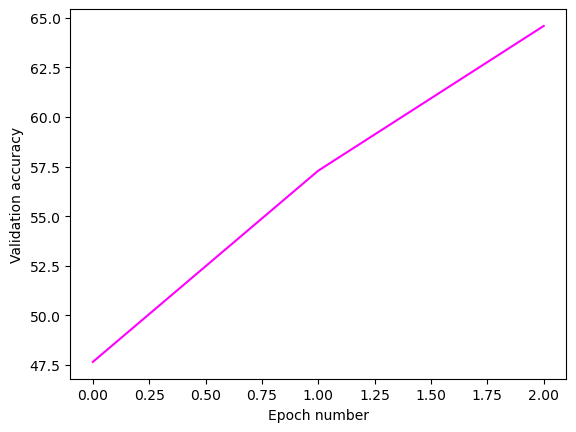

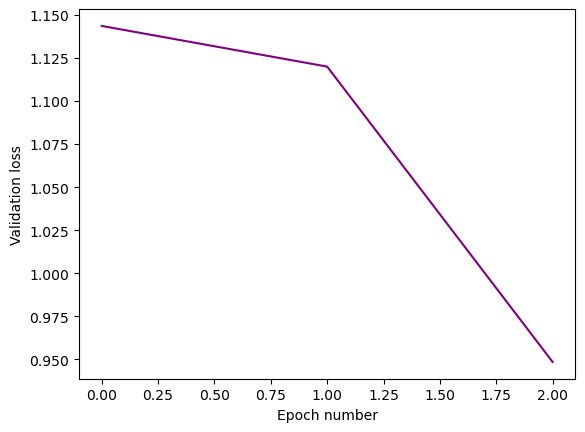

In [28]:
wandb.init(
    project="BGMP_HappyWhale",
    name="Joyce-HappyWhale-SpeciesDataset-hyperparameters_mod1", ##update this with your name
    config={"learning rate": learning_rate, # update
        "architecture": "CNN",
        "dataset": "Species",
        "epochs": epochs, "batch_size": batchsize}  # update
)

batch=0
num_epochs = epochs
train_losses, train_acc_list, val_losses, val_acc_list = [], [], [],[]

for epoch in range(num_epochs):
    # Setting model to "training mode"
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # For each batch of data within the loader
    for inputs, labels in train_loader:
        # Send our input images and their labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Inputting our training images into the model
        # and Predicting the image classification label
        outputs = model(inputs)
        # Figuring out the loss from our predictions
        loss = criterion(outputs, labels)
        # Compute gradients (aka backward pass)
        loss.backward()
        # Update model parameters
        optimizer.step()

        # Adding the loss to our running sum
        # Loss is calculated for each batch within an epoch
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        batch+=1
        print(f'Epoch [{epoch+1}/{num_epochs}] | Batch #{batch} | Batch Accuracy {(correct/total)*100:.2f}%')


    # Getting metrics for our training pass 
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_acc_list.append(train_acc)
    
    # Switching our model to "evaluation mode"
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    # Disable gradient calculation b/c we are evalulating the model
    with torch.no_grad():
        # Load in batches of our validation data
        for inputs, labels in val_loader:
            # Send test images and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Predict the image classification label
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            # Figuring out how many predicted labels = true labels
            correct += predicted.eq(labels).sum().item()

            # Figuring out the loss from our predictions
            loss = criterion(outputs, labels)
            # Adding the loss to our running sum
            # Loss is calculated for each batch within an epoch
            running_loss += loss.item() * inputs.size(0)
    # Getting our accuracy from our test data
    val_acc = 100. * correct / total
    val_acc_list.append(val_acc)
    # Getting the loss from our test data
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.2f}%')

    # log metrics to wandb
    wandb.log({"validation_accuracy": val_acc, "validation_loss": val_loss, "train_loss":train_loss})

wandb.finish()

plt.plot(range(epochs), val_acc_list, color = "magenta")
plt.xlabel("Epoch number")
plt.ylabel("Validation accuracy")
plt.show()  

plt.plot(range(epochs), val_losses, color = "purple")
plt.xlabel("Epoch number")
plt.ylabel("Validation loss")
plt.show()

/tmp/ipykernel_1182410/2764316866.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


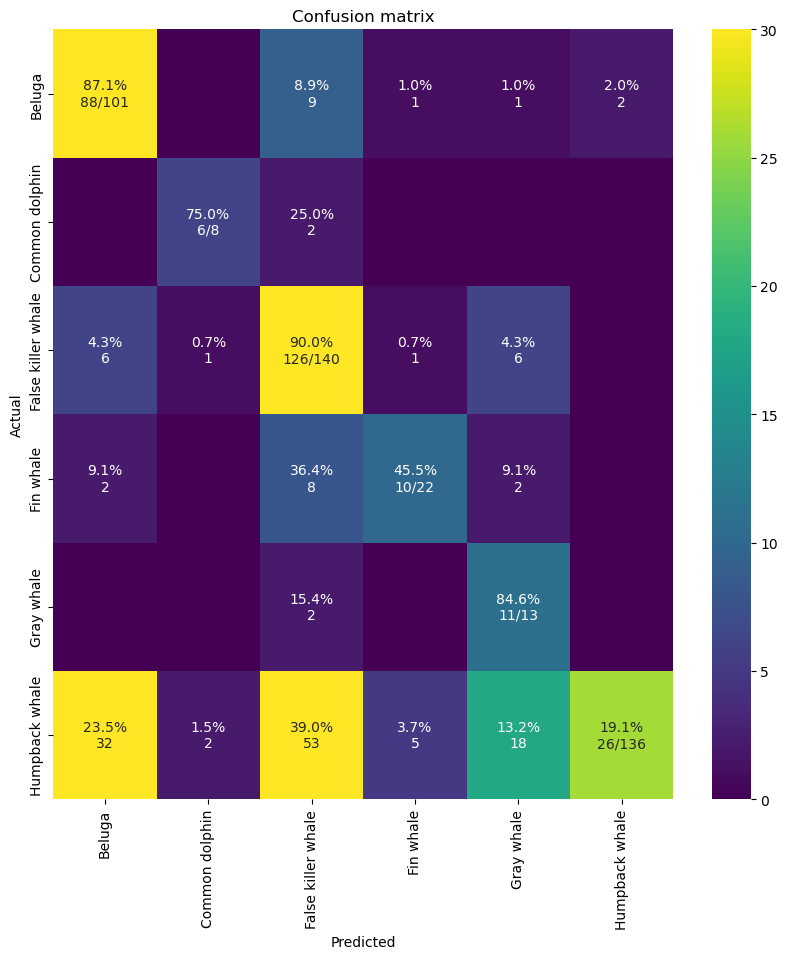

In [29]:
y_pred, y_true = predict(model, test_set)
cm_analysis(y_true, y_pred, "Confusion matrix")

<font color='magenta'>Were your changes successful? Do you have ideas why your changes were successful or not? 

The starting accuracy was 47.66%% and the final accuracy was 64.58%. The changes were successful, as this model is more accurate than the very first model we ran in this notebook. Reducing the learning rate may have helped make this model more accurate because smaller learning rates result in smaller weight updates, which can allow the model to converge more smoothly toward a minimum of the loss function instead of overshooting it. However, something to note is that smaller learning rates typically require more training epochs given the smaller changes made to the weights each update, but in mod1, I decreased the number of epochs.

#### Your Model 2 (10pts)

<font color='magenta'>Describe your changes to the model training process (either changing something about the model, a hyperparameter, how data was inputted into the model, or another aspect) and why you selected those changes.

I kept the same learning rate and number of epochs from mod1 in mod2, but also reduced the batch size from 48 to 32 to see how batch size would affect the accuracy and training time. Reducing the batch size would mean there are more parameter updates per epoch and and noisier gradient estimates, so I was curious as to whether this would increase or decrease the model training accuracy.

In [23]:
batchsize = 32 # reduce batch size from 48
learning_rate = 1e-4 # same as mod1, reduce learning rate from 1e-3
epochs = 3 # same as mod1, reduce epochs from 5

train_loader = DataLoader(train_set, batch_size=batchsize, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=batchsize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batchsize, drop_last=True, shuffle=True)

In [24]:
## Model
#########
## First, we create the basic block that will be used in our residual net
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        ## Conv1: convolution layer, batch normalization, ReLU activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        ## Conv2: convolution layer, batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        ## Shortcut connection: adds input to output
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    # The forward method calls on each layer
    def forward(self, x):
        ## Conv1: convolution layer, batch normalization, ReLU activation
        out = self.conv1(x) 
        out = self.bn1(out)
        out = self.relu(out)
        ## Conv2: convolution layer, batch normalization
        out = self.conv2(out)
        out = self.bn2(out)
        ## Shortcut connection
        out += self.shortcut(x)
        ## Final activation
        out = self.relu(out)
        return out

############
## Next, we put together these building blocks and create our residual net
class ResNet18(nn.Module):
    # specify the number of classes that we are predicting
    def __init__(self, num_classes=6):
        super(ResNet18, self).__init__()
        # In channels = Num pixels in H + Num pixels in W
        self.in_channels = 64
        
        # First convolution set (convolution, batch norm, relu)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Our building blocks
        # The numbers correspond to the matrix shape
        ### We increase the number of channels (i.e., the first number) as we go
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        # Average pooling 
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Final layer that makes the classification
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # First convolution set (convolution, batch norm, relu)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # Our 4 building blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        # Final layer that makes the classification
        out = self.fc(out)
        return out

## Getting our model and transferring it to the GPU
model = ResNet18().to(device)

#define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/joycew/.netrc.
wandb: Currently logged in as: joycew (BGMP_HappyWhale) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/3] | Batch #1 | Batch Accuracy 21.88%
Epoch [1/3] | Batch #2 | Batch Accuracy 23.44%
Epoch [1/3] | Batch #3 | Batch Accuracy 32.29%
Epoch [1/3] | Batch #4 | Batch Accuracy 35.94%
Epoch [1/3] | Batch #5 | Batch Accuracy 38.12%
Epoch [1/3] | Batch #6 | Batch Accuracy 40.10%
Epoch [1/3] | Batch #7 | Batch Accuracy 41.52%
Epoch [1/3] | Batch #8 | Batch Accuracy 42.97%
Epoch [1/3] | Batch #9 | Batch Accuracy 43.75%
Epoch [1/3] | Batch #10 | Batch Accuracy 45.00%
Epoch [1/3] | Batch #11 | Batch Accuracy 47.73%
Epoch [1/3] | Batch #12 | Batch Accuracy 49.22%
Epoch [1/3] | Batch #13 | Batch Accuracy 49.52%
Epoch [1/3] | Batch #14 | Batch Accuracy 50.67%
Epoch [1/3] | Batch #15 | Batch Accuracy 50.62%
Epoch [1/3] | Batch #16 | Batch Accuracy 51.56%
Epoch [1/3] | Batch #17 | Batch Accuracy 52.57%
Epoch [1/3] | Batch #18 | Batch Accuracy 53.12%
Epoch [1/3] | Batch #19 | Batch Accuracy 53.62%
Epoch [1/3] | Batch #20 | Batch Accuracy 53.12%
Epoch [1/3] | Batch #21 | Batch Accuracy 54.46%
E

train_loss,█▃▁
validation_accuracy,▁▆█
validation_loss,█▃▁
train_loss,0.71374
validation_accuracy,61.29808
validation_loss,0.99371


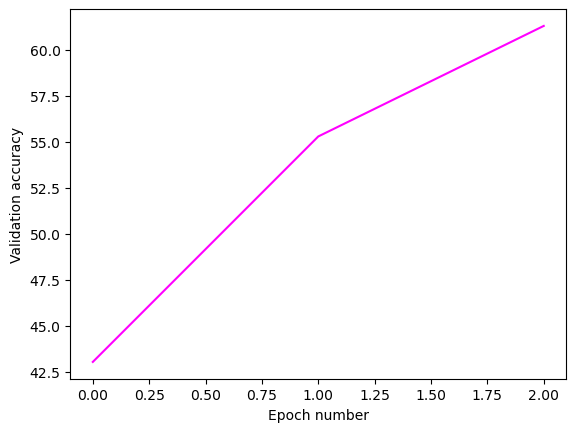

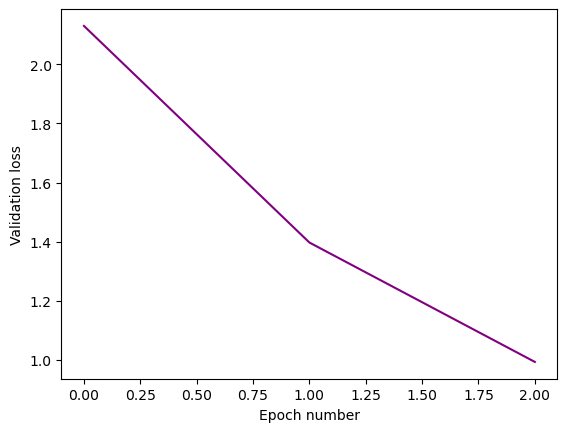

In [25]:
wandb.init(
    project="BGMP_HappyWhale",
    name="Joyce-HappyWhale-SpeciesDataset-hyperparameters_mod2", ##update this with your name
    config={"learning rate":learning_rate, # update
        "architecture": "CNN",
        "dataset": "Species",
        "epochs": epochs, "batch_size": batchsize}  # update
) 

batch=0
num_epochs = epochs
train_losses, train_acc_list, val_losses, val_acc_list = [], [], [],[]

for epoch in range(num_epochs):
    # Setting model to "training mode"
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # For each batch of data within the loader
    for inputs, labels in train_loader:
        # Send our input images and their labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Inputting our training images into the model
        # and Predicting the image classification label
        outputs = model(inputs)
        # Figuring out the loss from our predictions
        loss = criterion(outputs, labels)
        # Compute gradients (aka backward pass)
        loss.backward()
        # Update model parameters
        optimizer.step()

        # Adding the loss to our running sum
        # Loss is calculated for each batch within an epoch
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        batch+=1
        print(f'Epoch [{epoch+1}/{num_epochs}] | Batch #{batch} | Batch Accuracy {(correct/total)*100:.2f}%')


    # Getting metrics for our training pass 
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_acc_list.append(train_acc)
    
    # Switching our model to "evaluation mode"
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    # Disable gradient calculation b/c we are evalulating the model
    with torch.no_grad():
        # Load in batches of our validation data
        for inputs, labels in val_loader:
            # Send test images and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Predict the image classification label
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            # Figuring out how many predicted labels = true labels
            correct += predicted.eq(labels).sum().item()

            # Figuring out the loss from our predictions
            loss = criterion(outputs, labels)
            # Adding the loss to our running sum
            # Loss is calculated for each batch within an epoch
            running_loss += loss.item() * inputs.size(0)
    # Getting our accuracy from our test data
    val_acc = 100. * correct / total
    val_acc_list.append(val_acc)
    # Getting the loss from our test data
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.2f}%')

    # log metrics to wandb
    wandb.log({"validation_accuracy": val_acc, "validation_loss": val_loss, "train_loss":train_loss})

wandb.finish()

plt.plot(range(epochs), val_acc_list, color = "magenta")
plt.xlabel("Epoch number")
plt.ylabel("Validation accuracy")
plt.show()  

plt.plot(range(epochs), val_losses, color = "purple")
plt.xlabel("Epoch number")
plt.ylabel("Validation loss")
plt.show()

/tmp/ipykernel_2552726/2764316866.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


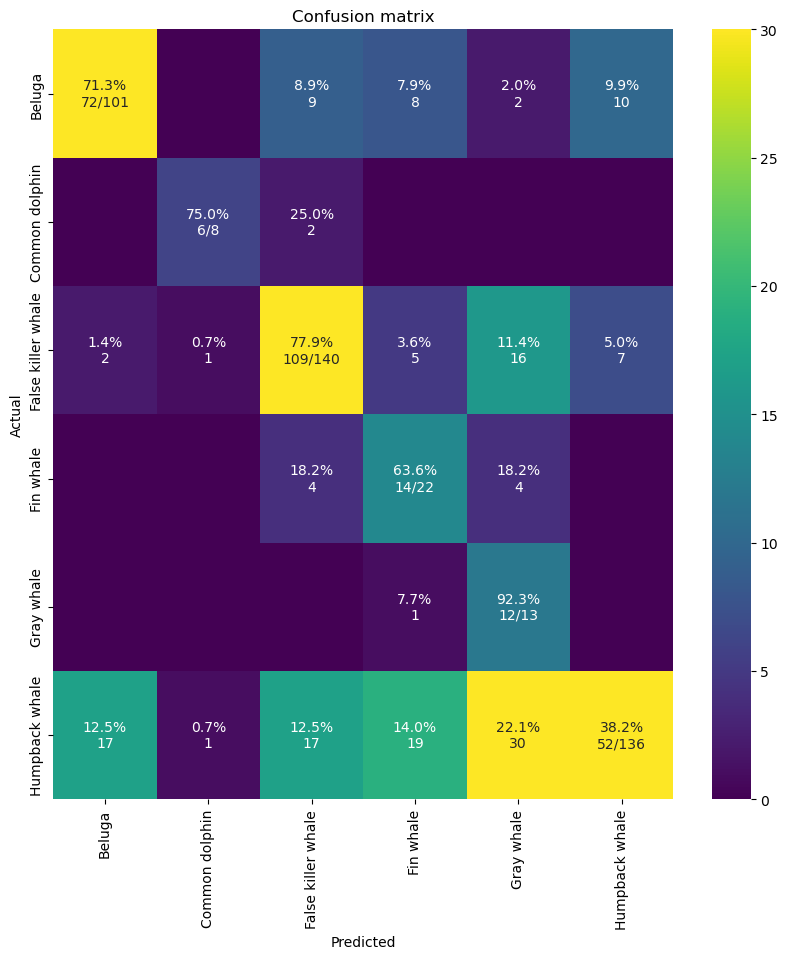

In [26]:
y_pred, y_true = predict(model, test_set)
cm_analysis(y_true, y_pred, "Confusion matrix")

<font color='magenta'>Were your changes successful? Do you have ideas why your changes were successful or not? 

The starting accuracy was 43.03% and the final accuracy was 61.30%. Overall, the change in batch size compared to mod1 was not successful. Reducing the batch size would mean there are more parameter updates per epoch and and noisier gradient estimates of a loss function. A larger batch size, on the other hand, would calculate a better estimate of the true gradient, so it makes sense that decreasing the batch size decreases the model training accuracy. That, paired with the small number of epochs when epochs should be larger when learning rates are on the small side (two hyperparameters I passed down from mod1), results in an unsuccessful mod2.

#### Your Model 3 (10 pts)

<font color='magenta'>Describe your changes to the model training process (either changing something about the model, a hyperparameter, how data was inputted into the model, or another aspect) and why you selected those changes.

I kept the same batch size, learning rate, and epochs as mod2 to compare how mod3 would perform with the same hyperparameters, but a different, pre-made model architecture for ResNet18 with pre-trained weights instead of our custom-built ResNet18. ResNet18_Weights.DEFAULT is equivalent to ResNet18_Weights.IMAGENET1K_V1 ([source](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)). I was curious as to whether pre-trained weights with set transformations would increase accuracy on our training set.

In [22]:
batchsize = 32 # same as mod2, reduce batch size from 48
learning_rate = 1e-4 # same as mod1, reduce learning rate from 1e-3
epochs = 3 # same as mod1, reduce epochs from 5

train_loader = DataLoader(train_set, batch_size=batchsize, drop_last=True, sampler=train_sampler)
val_loader = DataLoader(val_set, batch_size=batchsize, drop_last=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batchsize, drop_last=True, shuffle=True)

In [23]:
## Model: Changing the model to a different pre-made model architecture, with pre-trained weights
#########
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights

num_classes = 6 # same as mod1 and mod2
weights = ResNet18_Weights.DEFAULT

# Pre-trained torchvision ResNet18, ResNet18_Weights.DEFAULT (aka ResNet18_Weights.IMAGENET1K_V1)
model = resnet18(weights=weights)

# Replace classification head
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

## Getting our model and transferring it to the GPU
model = model.to(device)

# Make sure transforms match the pre-trained weights, ResNet18_Weights.DEFAULT (aka ResNet18_Weights.IMAGENET1K_V1)
preprocess = weights.transforms()
train_set.transform = preprocess
val_set.transform = preprocess
test_set.transform = preprocess

#define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/joycew/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 384MB/s]


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/joycew/.netrc.
wandb: Currently logged in as: joycew (BGMP_HappyWhale) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/3] | Batch #1 | Batch Accuracy 21.88%
Epoch [1/3] | Batch #2 | Batch Accuracy 29.69%
Epoch [1/3] | Batch #3 | Batch Accuracy 33.33%
Epoch [1/3] | Batch #4 | Batch Accuracy 35.16%
Epoch [1/3] | Batch #5 | Batch Accuracy 38.12%
Epoch [1/3] | Batch #6 | Batch Accuracy 40.62%
Epoch [1/3] | Batch #7 | Batch Accuracy 43.75%
Epoch [1/3] | Batch #8 | Batch Accuracy 45.31%
Epoch [1/3] | Batch #9 | Batch Accuracy 44.79%
Epoch [1/3] | Batch #10 | Batch Accuracy 47.50%
Epoch [1/3] | Batch #11 | Batch Accuracy 50.00%
Epoch [1/3] | Batch #12 | Batch Accuracy 52.34%
Epoch [1/3] | Batch #13 | Batch Accuracy 54.57%
Epoch [1/3] | Batch #14 | Batch Accuracy 56.47%
Epoch [1/3] | Batch #15 | Batch Accuracy 58.33%
Epoch [1/3] | Batch #16 | Batch Accuracy 59.57%
Epoch [1/3] | Batch #17 | Batch Accuracy 60.85%
Epoch [1/3] | Batch #18 | Batch Accuracy 61.63%
Epoch [1/3] | Batch #19 | Batch Accuracy 62.66%
Epoch [1/3] | Batch #20 | Batch Accuracy 63.75%
Epoch [1/3] | Batch #21 | Batch Accuracy 64.88%
E

train_loss,█▂▁
validation_accuracy,▁▅█
validation_loss,█▁▁
train_loss,0.09
validation_accuracy,95.67308
validation_loss,0.12583


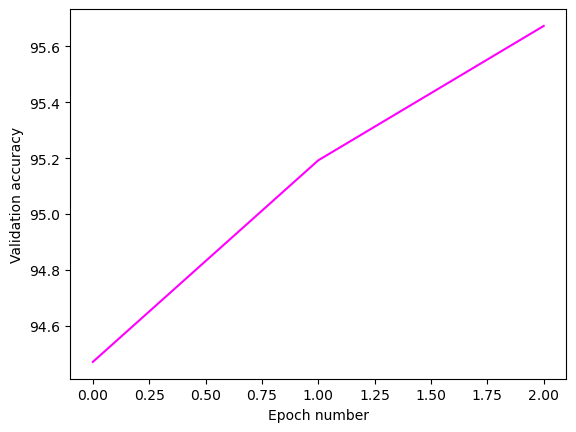

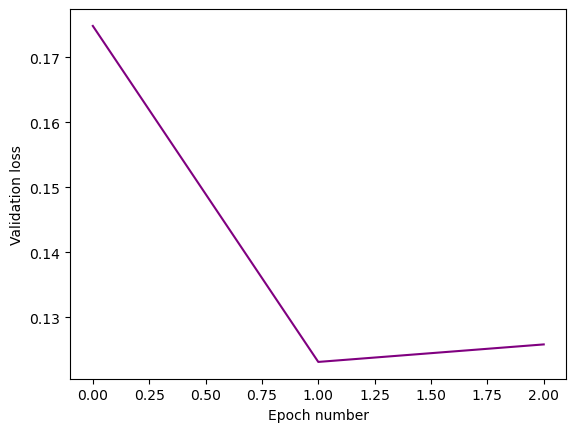

In [24]:
wandb.init(
    project="BGMP_HappyWhale",
    name="Joyce-HappyWhale-SpeciesDataset-hyperparameters_mod3", ##update this with your name
    config={"learning rate": learning_rate, # update
        "architecture": "CNN",
        "dataset": "Species",
        "epochs": epochs, "batch_size": batchsize}  # update
) 

batch=0
num_epochs = epochs
train_losses, train_acc_list, val_losses, val_acc_list = [], [], [],[]

for epoch in range(num_epochs):
    # Setting model to "training mode"
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    # For each batch of data within the loader
    for inputs, labels in train_loader:
        # Send our input images and their labels to the GPU
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Inputting our training images into the model
        # and Predicting the image classification label
        outputs = model(inputs)
        # Figuring out the loss from our predictions
        loss = criterion(outputs, labels)
        # Compute gradients (aka backward pass)
        loss.backward()
        # Update model parameters
        optimizer.step()

        # Adding the loss to our running sum
        # Loss is calculated for each batch within an epoch
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        batch+=1
        print(f'Epoch [{epoch+1}/{num_epochs}] | Batch #{batch} | Batch Accuracy {(correct/total)*100:.2f}%')


    # Getting metrics for our training pass 
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100. * correct / total
    train_losses.append(train_loss)
    train_acc_list.append(train_acc)
    
    # Switching our model to "evaluation mode"
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    # Disable gradient calculation b/c we are evalulating the model
    with torch.no_grad():
        # Load in batches of our validation data
        for inputs, labels in val_loader:
            # Send test images and labels to the GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Predict the image classification label
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            # Figuring out how many predicted labels = true labels
            correct += predicted.eq(labels).sum().item()

            # Figuring out the loss from our predictions
            loss = criterion(outputs, labels)
            # Adding the loss to our running sum
            # Loss is calculated for each batch within an epoch
            running_loss += loss.item() * inputs.size(0)
    # Getting our accuracy from our test data
    val_acc = 100. * correct / total
    val_acc_list.append(val_acc)
    # Getting the loss from our test data
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}% | Val Loss: {val_loss:.2f}%')

    # log metrics to wandb
    wandb.log({"validation_accuracy": val_acc, "validation_loss": val_loss, "train_loss":train_loss})

wandb.finish()

plt.plot(range(epochs), val_acc_list, color = "magenta")
plt.xlabel("Epoch number")
plt.ylabel("Validation accuracy")
plt.show()  

plt.plot(range(epochs), val_losses, color = "purple")
plt.xlabel("Epoch number")
plt.ylabel("Validation loss")
plt.show()

/tmp/ipykernel_1182410/2764316866.py:50: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)


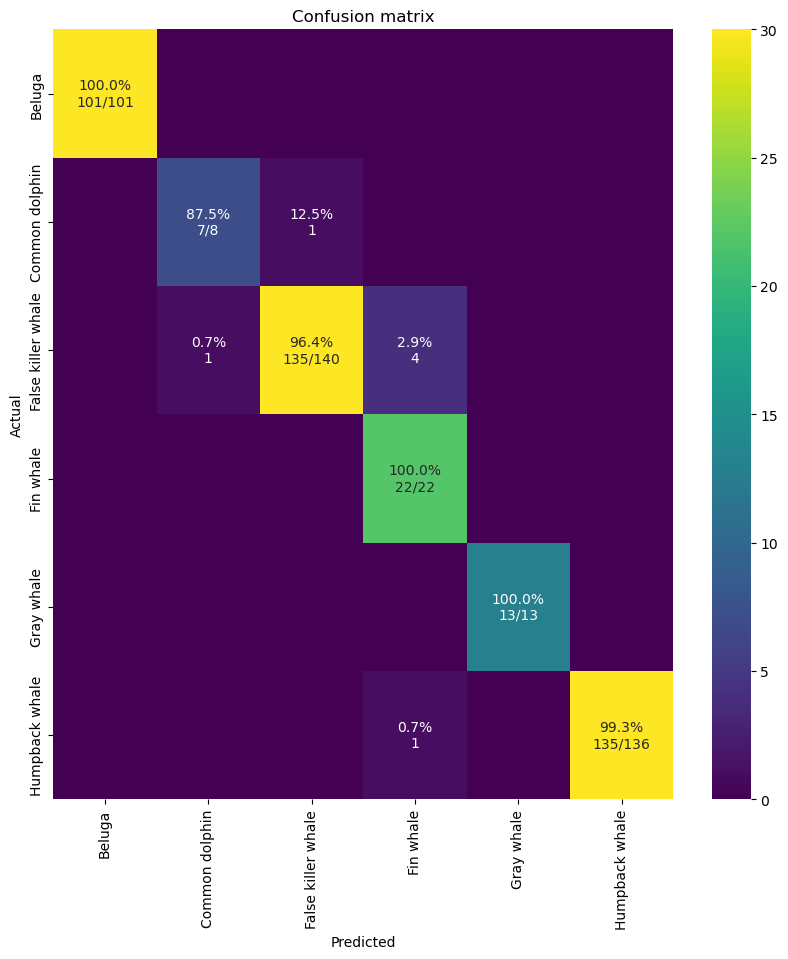

In [25]:
y_pred, y_true = predict(model, test_set)
cm_analysis(y_true, y_pred, "Confusion matrix")

<font color='magenta'>Were your changes successful? Do you have ideas why your changes were successful or not? 

The starting accuracy was 94.47% and the final accuracy was 95.67%. The confusion matrix showed nearly all species were predicted pretty accurately. Yes, these changes were very successful! I suppose the pre-trained weights and using an already established architecture for ResNet18 has its benefits—compared to a model we built from scratch, this resnet18 model with pre-trained weights, which already has a high reported starting accuracy and has been trained on many different categories, has adjusted convolutional layer settings and other weights that have been tested to predict classes efficiently and accurately.

<font color='magenta'>Summarize your 3 steps, their success, and what you learned (5 pts)

*Your answer here*